<a href="https://colab.research.google.com/github/GOMTAE/INTRO2DL/blob/main/%5BSKELETON%5D_Lecture4_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from tensorflow import summary
import tensorflow as tf

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
import os #reading files
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__) # version of cuda / we dont have to worry about this

1.7.0+cu101


### Import your drive's contents!

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Let's load the CIFAR10 dataset


In [14]:
data_path = './cifar10'
model_dir = './drive/MyDrive/Codes/models'
batch_size = 64
# USE torchvision.datasets.CIFAR10(...)
tensor_transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.CIFAR10(data_path, True, transform = tensor_transform ,download=True)
test_dataset = torchvision.datasets.CIFAR10(data_path, False, transform = tensor_transform, download=True)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


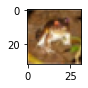

In [13]:
train_dataset[0]
plt.figure(figsize=(1,1))
plt.imshow(train_dataset[0][0].permute(1, 2 ,0)) # D W H -> W H D

### Choose your device - use GPU or not?

In [15]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Try to sample out one data point from dataloader

In [23]:
sample = next(iter(train_dataloader))
# sample = test_dataset[1]
print(sample[0].shape)
print(sample[1])

torch.Size([64, 3, 32, 32])
tensor([9, 7, 3, 7, 3, 5, 9, 3, 2, 9, 2, 7, 1, 3, 5, 4, 4, 6, 3, 5, 2, 0, 4, 3,
        0, 4, 7, 9, 3, 4, 0, 9, 3, 3, 1, 7, 4, 2, 6, 1, 7, 6, 0, 1, 8, 6, 5, 0,
        8, 1, 8, 8, 4, 3, 8, 6, 6, 9, 4, 4, 9, 4, 8, 5])


10


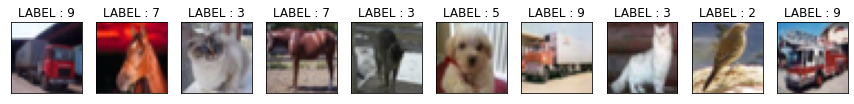

In [27]:
fig, ax = plt.subplots(1, 10, figsize=(15, 4))
print(len(ax))
for plot_idx in range(10):
    ax[plot_idx].imshow(sample[0][plot_idx].permute(1, 2, 0))
    ax[plot_idx].set_title('LABEL : {}'.format(sample[1][plot_idx]))
    ax[plot_idx].set_xticks([])
    ax[plot_idx].set_yticks([])
plt.show()

### Define the Multiple Layer Perceptrons

In [36]:
class CNNs(nn.Module):
    def __init__(self, channels=[32, 64, 128], img_size = 32, dim_output=10):
        super(CNNs, self).__init__()

        # TODO : build a model with three conv layers
        # number of channels goes up like : 3 -> 32 -> 64 -> 128
        # After the conv, downsample the image with maxpool, so that image size can be reduced
        # After the maxpool, add activation (ReLU)
        # conv -> pool -> relu -> conv -> pool -> relu -> conv -> pool -> relu # relu pool also possible
        # After this, flatten the spatial feature,
        # after flattening it, add fully connected layer so that 
        # (flattened_feature) -> 128 dim feature -> 10 dim output, can be generated

        # Try to add batch norm, dropout.
        
        self.channels = channels
        self.conv1 = nn.Conv2d(3, self.channels[0], kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.channels[0], self.channels[1], kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.channels[1], self.channels[2], kernel_size=3, stride=1, padding=1)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.activation = nn.ReLu()
        self.fc1 = nn.Linear(self.channels[-1]*(self.img_size//8))**2, 128) #put input dimension by urself
        self.fc2 = nn.Linear(128, )
        

    def forward(self, img):
        batch_size = img.shape[0]

        print('img shape : ', img.shape)
        # 1st block
        out = self.conv1(img)
        print('out shape after conv1 : ', out.shape)
        out = self.max_pool(out)
        print('out shape after pool1 : ', out.shape)
        out = self.activation(out)
        print('out shape after activation : ', out.shape)

        # 2nd block
        out = self.conv2(out)
        print('out shape after conv2 : ', out.shape)
        out = self.max_pool(out)
        print('out shape after pool2 : ', out.shape)
        out = self.activation(out)
        print('out shape after activation : ', out.shape)

        # 3rd block
        out = self.conv2(out)
        print('out shape after conv3 : ', out.shape)
        out = self.max_pool(out)
        print('out shape after pool3 : ', out.shape)
        out = self.activation(out)
        print('out shape after activation : ', out.shape)

        ## Flattening
        out = out.view(batch_size, -1)
        print

        ## Fully connected layer

### Define the Model

In [37]:
model = CNNs()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
# # weight decay?

print(model)
print('sample shape : ', sample[0].shape)
sample_out = model(sample[0].to(device))

AttributeError: ignored

### Define functions for train/test

In [38]:
def train(model, optimizer, sample):
    model.train()

    criterion = nn.CrossEntropyLoss()
    
    # reset optimizer's gradient
    optimizer.zero_grad()

    # define input and output
    img = sample[0].float().to(device)
    label = sample[1].long().to(device)
    
    # get the prediction
    pred = model(img) # B 10 (Batchsize and output dim)

    pred_loss = criterion(pred, label)
    
    # Try to add the regularization loss!

    num_correct = sum(torch.argmax(pred, dim=1) == label)
    
    pred_loss.backward()
    optimizer.step()

    return pred_loss.item(), num_correct.item()

In [ ]:
def test(model, sample):
    model.eval()

    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        # define input and output
        img = ...
        label = ...
        
        # get the prediction
        pred = model(img)
        
        pred_loss = criterion(pred, label)

        num_correct = sum(torch.argmax(pred, dim=1) == label)

    return pred_loss.item(), num_correct.item()

### Prepare the Tensorboard

In [ ]:
train_log_dir = './runs/train_normal'
train_summary_writer = summary.create_file_writer(train_log_dir)
test_log_dir = './runs/test_normal'
test_summary_writer = summary.create_file_writer(test_log_dir)  #conventional memorize!

In [ ]:
%tensorboard --logdir runs

### Run Training

In [ ]:
max_epoch = 200
tmp_path = './checkpoint.pth'

for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    # Load the saved MODEL AND OPTIMIZER after evaluation.
    if epoch > 0:
        checkpoint = torch.load(tmp_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # how about learning rate scheduler?

    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        curr_loss, num_correct = train(model, optimizer, sample)
        train_loss += curr_loss / len(train_dataloader)
        train_accu += num_correct / len(train_dataset)

    # Write the current loss and accuracy to the Tensorboard
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step=epoch)                
        tf.summary.scalar('accuracy', train_accu, step=epoch)                

    # save the model and optimizer's information before the evaulation
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        # how about learning rate scheduler?
    }
    torch.save(checkpoint, tmp_path)
    torch.save(model.state_dict(), os.path.join(model_dir, 'recent.pth'))
    
    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    for idx, sample in enumerate(test_dataloader):
        curr_loss, num_correct = test(model, sample)
        test_loss += curr_loss / len(test_dataloader)
        test_accu += num_correct / len(test_dataloader)

    # Write the current loss and accuracy to the Tensorboard
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss, step=epoch)
        tf.summary.scalar('accuracy', test_accu, step=epoch) 